In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner

import seaborn as sns
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


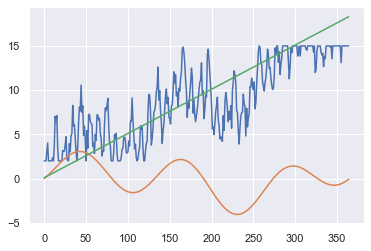

In [5]:
P = 365
P2 = 30.5
N = 365
t = np.arange(N)

# Coefficients
an = [1, 0.5, -1.5]
bn = [1, -0.5, 1.5]

an2 = [-1, 0.5, -1.5]
bn2 = [1, -0.5, 2]

s = [a*np.cos(2*np.pi*(n+1)*t/P) + b*np.sin(2*np.pi*(n+1)*t/P)
     for n,(a,b) in enumerate(zip(an, bn))]
s2 = [a*np.cos(2*np.pi*(n+1)*t/P2) + b*np.sin(2*np.pi*(n+1)*t/P2)
     for n,(a,b) in enumerate(zip(an2, bn2))]

trend = 0.05*t + 0.1

y = sum(s) + sum(s2) + trend
noise = np.random.randn(*y.shape)
y += noise
y = np.clip(y, 2, 15)

plt.plot(t, y)
plt.plot(t, sum(s))
# plt.plot(t, sum(s2))
plt.plot(t, trend)
plt.show()

In [28]:
class TimeSeries(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return torch.Tensor([self.x[i]]), torch.Tensor([self.y[i]])

In [29]:
train_len = int(0.8*len(y))
train_ds = TimeSeries(t[:train_len], y[:train_len])
test_ds = TimeSeries(t[train_len:], y[train_len:])
bs = 96
db = DataBunch.create(train_ds, test_ds, bs=bs)

In [30]:
class FourierModel(nn.Module):
    def __init__(self, y_n=7, m_n=5, w_n=0, 
                 P1=365.25, P2=30.5, P3=7):
        super().__init__()
        self.y_n, self.m_n, self.w_n = y_n, m_n, w_n
        np = [(n+1, P1) for n in range(y_n)]
        np += [(n+1, P2) for n in range(m_n)]
        np += [(n+1, P3) for n in range(w_n)]
        self.np = np
        self.linear = nn.Linear(2*len(np), 1, bias=False)
        
    def forward(self, x):
        cos = [torch.cos(2*np.pi*n*x/p) for n,p in self.np]
        sin = [torch.sin(2*np.pi*n*x/p) for n,p in self.np]
        x = torch.cat(cos + sin, dim=1)
                
        return self.linear(x)

In [31]:
class Squasher(nn.Module):
    def __init__(self, low, high, alpha=0.01):
        super().__init__()
        self.L, self.H, self.alpha = low, high, alpha
    def forward(self, x): 
        x[x < self.L] = self.alpha * (x[x < self.L] - self.L) + self.L
        x[x > self.H] = self.alpha * (x[x > self.H] - self.H) + self.H
        return x

In [44]:
class Model(nn.Module):
    def __init__(self, low, high, y_n=7, m_n=0, w_n=0):
        super().__init__()
        self.trend = nn.Linear(1, 1)
        self.seasonal = FourierModel(y_n, m_n, w_n)
        self.squash = Squasher(low, high)

    def forward(self, x):
        return self.squash(self.seasonal(x) + self.trend(x))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


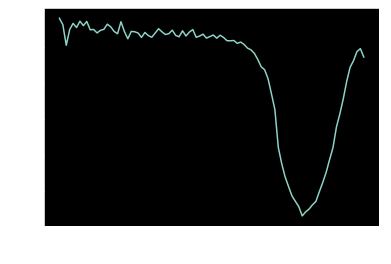

In [45]:
model = Model(2, 15)
learner = Learner(db, model, loss_func=F.l1_loss)
wd = 0
learner.lr_find(wd=wd)
learner.recorder.plot(skip_end=0)

In [48]:
epochs = 20
learner.fit_one_cycle(epochs, 5e-2, wd=wd)

epoch,train_loss,valid_loss,time
0,5.600108,13.054942,00:00
1,5.588957,13.041765,00:00
2,5.585841,13.010555,00:00
3,5.578128,12.955606,00:00
4,5.575556,12.876348,00:00
5,5.570248,12.780650,00:00
6,5.543157,0.306491,00:00
7,5.114636,0.286071,00:00
8,4.719272,0.764669,00:00
9,4.397726,0.288611,00:00


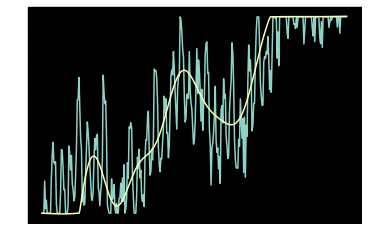

In [49]:
y2 = learner.model(torch.Tensor(t)[:,None])
plt.plot(t, y)
plt.plot(t, y2.detach().cpu().numpy().squeeze())
plt.show()

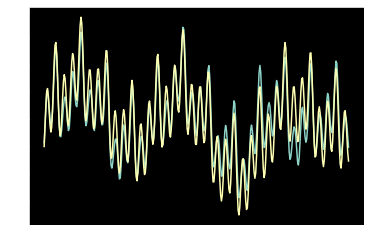

In [42]:
s_infer = learner.model.seasonal(torch.Tensor(t)[:,None])
plt.plot(t, s_infer.detach().cpu().numpy())
plt.plot(t, sum(s) + sum(s2))
plt.show()

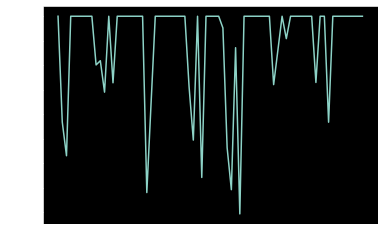

In [43]:
plt.plot(t[train_len:], y[train_len:])